# Importing Libraries

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tf_keras.models import Sequential
from tf_keras.layers import SimpleRNN, Dense, Dropout, LSTM, BatchNormalization
from tf_keras.regularizers import l2
from tf_keras.metrics import Precision, AUC
from tf_keras.optimizers import Adam

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Helper Functions

## Visualise Loss

In [57]:
def visualise_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.show()
    return None

## Visualise Confusion Matrix

In [76]:
def get_conf_mat(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)  # For binary classification, probabilities will be returned

    # Step 2: Convert probabilities to class labels
    y_pred_classes = (y_pred_probs > 0.5).astype("int32")  # For binary classification
    try:
        y_pred_classes = [pred[0][0] for pred in y_pred_classes]
    except:
        print("ok")
    # Step 3: Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    return conf_matrix

def visualise_mat(mat):
    sns.heatmap(mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    return None

## Get Scores

In [77]:
def get_score(mat):
    cur_mat = mat
    acc = (cur_mat[0][0] + cur_mat[1][1])/sum(sum(cur_mat))
    pre = (cur_mat[1][1])/(cur_mat[1][1] + cur_mat[0][1])
    rec = (cur_mat[1][1])/(cur_mat[1][1] + cur_mat[1][0])
    f1 = (2*pre*rec)/(pre + rec)

    print(f"Accuracy: {round(acc, 2)}")
    print(f"Precision: {round(pre, 2)}")
    print(f"Recall: {round(rec, 2)}")
    print(f"F1 Score: {round(f1, 2)}")
    return None

# RNN + TFIDF

In [2]:
# Code for this dataset is in another notebook
sent_df = pd.read_csv("sentiment.csv")

In [3]:
df = sent_df.dropna(subset=["comment", "label"])

In [4]:
X = df["comment"]
X

0                                                    nc nh
1                          significant spending tax dollar
2                                  bother he sign weakness
3        conservatism ideology reaction liberalism deve...
4               maybe control certainly evidence collusion
                               ...                        
82754                          woman lead man anyway bible
82755                                          thank union
82756                                                    o
82757                        slavs get country call kosovo
82758                            value capitalism imprison
Name: comment, Length: 81750, dtype: object

In [5]:
y = df["label"]
y

0        0
1        0
2        0
3        0
4        0
        ..
82754    1
82755    1
82756    1
82757    1
82758    1
Name: label, Length: 81750, dtype: int64

In [6]:
vectorizer = TfidfVectorizer()
tfidf_mat = vectorizer.fit_transform(list(X))

In [7]:
tfidf_df = pd.DataFrame(tfidf_mat.toarray(), columns=vectorizer.get_feature_names_out())

In [69]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_mat.toarray(), df["label"], test_size=0.2, random_state=42)

In [9]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [27]:
# Build the RNN model
tfidf_model = Sequential()
tfidf_model.add(SimpleRNN(16, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
tfidf_model.add(Dropout(0.2))
tfidf_model.add(Dense(1, activation='sigmoid'))

In [28]:
# Compile the model
tfidf_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[Precision(), AUC()])

# Train the model
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
tfidf_history = tfidf_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1635/1635 [==============================] - 6s 3ms/step - loss: 0.6161 - precision_7: 0.6557 - auc_7: 0.6812 - val_loss: 0.5912 - val_precision_7: 0.6986 - val_auc_7: 0.7182
Epoch 2/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.5495 - precision_7: 0.7440 - auc_7: 0.7730 - val_loss: 0.6033 - val_precision_7: 0.6970 - val_auc_7: 0.7110
Epoch 3/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.5209 - precision_7: 0.7635 - auc_7: 0.8010 - val_loss: 0.6193 - val_precision_7: 0.7155 - val_auc_7: 0.7038
Epoch 4/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.5041 - precision_7: 0.7745 - auc_7: 0.8154 - val_loss: 0.6354 - val_precision_7: 0.7075 - val_auc_7: 0.6953
Epoch 5/10
1635/1635 [==============================] - 4s 2ms/step - loss: 0.4937 - precision_7: 0.7797 - auc_7: 0.8236 - val_loss: 0.6537 - val_precision_7: 0.7103 - val_auc_7: 0.6906
Epoch 6/10
1635/1635 [==============================] - 4s 2ms/step - 

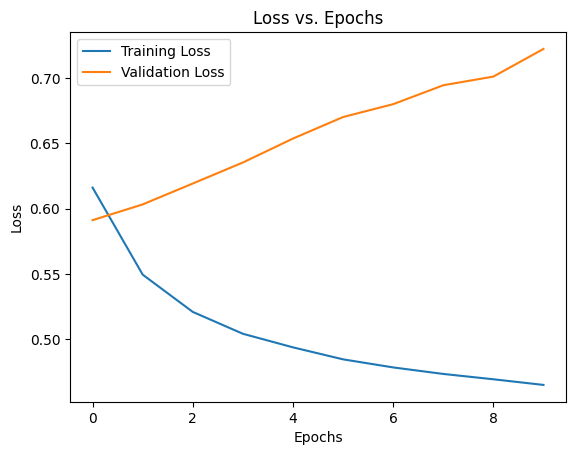

In [56]:
visualise_loss(tfidf_history)

In [30]:
tfidf_model.evaluate(X_test_reshaped, y_test)

511/511 [==============================] - 1s 1ms/step - loss: 0.7204 - precision_7: 0.7057 - auc_7: 0.6787


[0.7203512191772461, 0.7056681513786316, 0.6786755919456482]

In [71]:
tfidf_conf_matrix = get_conf_mat(tfidf_model, X_test_reshaped, y_test)
tfidf_conf_matrix

511/511 [==============================] - 1s 1ms/step


array([[3104, 3152],
       [2537, 7557]], dtype=int64)

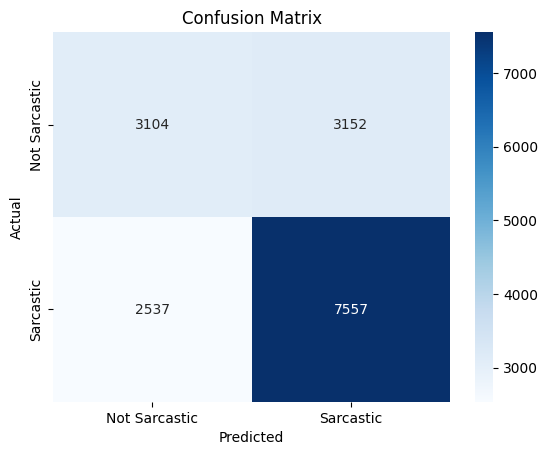

In [78]:
visualise_mat(tfidf_conf_matrix)

In [79]:
get_score(tfidf_conf_matrix)

Accuracy: 0.65
Precision: 0.71
Recall: 0.75
F1 Score: 0.73


# RNN + Bert

## Getting Bert Embedding

In [36]:
# Code for Bert Embedding is in another notebook
train_df = pd.read_pickle('bert_embeddings_no_pooling_train.pkl')

In [37]:
train_df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,bert_comment,seq_len
0,0,nc and nh.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"yeah, i get that argument. at this point, i'd ...","[[[-0.26591256, -0.29882812, -0.040224716, -0....",3
10,0,i think a significant amount would be against ...,ThisIsNotKimJongUn,politics,92,92,0,2016-09,2016-09-20 17:53:52,i bet if that money was poured into college de...,"[[[0.075774364, 0.03500098, -0.04244519, -0.05...",15
17,0,because it's what really bothers him... and it...,kozmo1313,politics,15,-1,-1,2016-12,2016-12-26 20:10:45,he actually acts like a moody emo girl on twit...,"[[[0.03299582, 0.04939469, -0.08288911, -0.163...",12
22,0,conservatism as an ideology is for sure a reac...,MayorMcCheese59,politics,1,-1,-1,2016-12,2016-12-24 00:04:06,"i still doubt that ""all conservatives stand fo...","[[[-0.1579521, -0.00796949, -0.33657235, -0.09...",29
23,0,"maybe not control, but certainly that is evide...",SunTzu-,politics,1,-1,-1,2016-10,2016-10-13 20:48:14,today russian media tweeted out that wikileaks...,"[[[-0.093258426, -0.08815382, -0.058376268, -0...",10
...,...,...,...,...,...,...,...,...,...,...,...,...
1010808,1,women shouldn't lead men anyway... it's in the...,musashiXXX,news,1,1,0,2009-09,2009-09-01 14:14:27,read the comment section. the glenn beck fluff...,"[[[0.13645245, -0.047203332, -0.19071074, -0.0...",9
1010811,1,thank you unions.,boot20,politics,2,2,0,2009-05,2009-05-28 05:18:11,no wonder california is broke - the $350k nurs...,"[[[0.00220339, 0.035776787, 0.047628716, -0.05...",3
1010820,1,:o,DiarrheaMonkey,politics,1,1,0,2009-04,2009-04-15 03:02:01,us combat troops may stay in northern iraq aft...,"[[[-0.1890865, -0.13287237, 0.17621507, -0.315...",1
1010824,1,the slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,i've always been unsettled by that. i hear a l...,"[[[-0.16559607, -0.102044925, -0.23074053, -0....",11


### Getting X

In [38]:
X = train_df["bert_comment"]
X

0          [[[-0.26591256, -0.29882812, -0.040224716, -0....
10         [[[0.075774364, 0.03500098, -0.04244519, -0.05...
17         [[[0.03299582, 0.04939469, -0.08288911, -0.163...
22         [[[-0.1579521, -0.00796949, -0.33657235, -0.09...
23         [[[-0.093258426, -0.08815382, -0.058376268, -0...
                                 ...                        
1010808    [[[0.13645245, -0.047203332, -0.19071074, -0.0...
1010811    [[[0.00220339, 0.035776787, 0.047628716, -0.05...
1010820    [[[-0.1890865, -0.13287237, 0.17621507, -0.315...
1010824    [[[-0.16559607, -0.102044925, -0.23074053, -0....
1010825    [[[-0.17583698, -0.0315043, -0.066449955, 0.06...
Name: bert_comment, Length: 82764, dtype: object

### Getting y

In [39]:
y = train_df["label"]
y

0          0
10         0
17         0
22         0
23         0
          ..
1010808    1
1010811    1
1010820    1
1010824    1
1010825    1
Name: label, Length: 82764, dtype: int64

## Padding Function

In [40]:
# Assuming x_train is your data array with varying sequence lengths
desired_shape = (15, 768)
# Define a function to pad or truncate each sequence to the desired shape
def pad(seq, target_shape):
    # Pad with zeros if the sequence is shorter than the target length
    if seq.shape[1] <= target_shape[0]:
        padding_needed = target_shape[0] - seq.shape[1]
        # Pad at the end of the sequence
        padding = np.zeros((padding_needed, target_shape[1]), dtype=seq.dtype)
        return np.vstack([seq[0], padding])
    
    # Return as-is if the sequence already matches the target length
    return seq

## Training

### Simple Model to Compare with TFIDF

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
X_train_padded = np.array([pad(seq, desired_shape) for seq in X_train])
X_test_padded = np.array([pad(seq, desired_shape) for seq in X_test])

In [210]:
bert1_model = Sequential()
bert1_model.add(SimpleRNN(16, input_shape=(15, 768)))
bert1_model.add(Dropout(0.2))
bert1_model.add(Dense(1, activation='sigmoid'))

In [48]:
# Compile the model
bert1_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[Precision(), AUC()])

# Train the model
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert1_history = bert1_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1656/1656 [==============================] - 5s 3ms/step - loss: 0.6201 - precision_9: 0.6894 - auc_9: 0.6798 - val_loss: 0.5797 - val_precision_9: 0.7179 - val_auc_9: 0.7391
Epoch 2/10
1656/1656 [==============================] - 4s 2ms/step - loss: 0.5883 - precision_9: 0.7171 - auc_9: 0.7278 - val_loss: 0.5834 - val_precision_9: 0.7743 - val_auc_9: 0.7470
Epoch 3/10
1656/1656 [==============================] - 4s 2ms/step - loss: 0.5771 - precision_9: 0.7312 - auc_9: 0.7431 - val_loss: 0.5661 - val_precision_9: 0.7394 - val_auc_9: 0.7552
Epoch 4/10
1656/1656 [==============================] - 4s 2ms/step - loss: 0.5721 - precision_9: 0.7355 - auc_9: 0.7489 - val_loss: 0.5634 - val_precision_9: 0.7273 - val_auc_9: 0.7622
Epoch 5/10
1656/1656 [==============================] - 4s 2ms/step - loss: 0.5661 - precision_9: 0.7398 - auc_9: 0.7560 - val_loss: 0.5605 - val_precision_9: 0.7430 - val_auc_9: 0.7611
Epoch 6/10
1656/1656 [==============================] - 4s 2ms/step - 

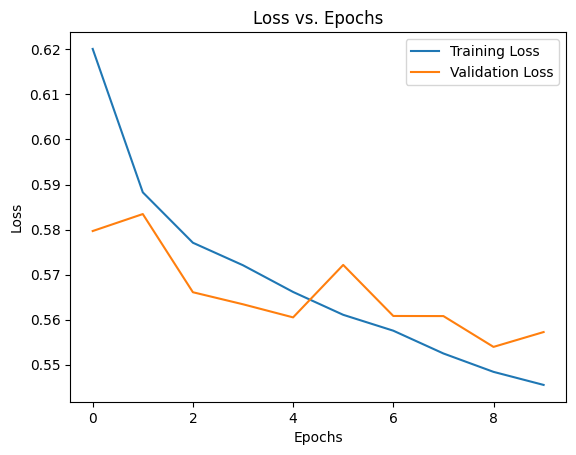

In [80]:
visualise_loss(bert1_history)

In [50]:
bert1_model.evaluate(X_test_padded, y_test)

518/518 [==============================] - 1s 1ms/step - loss: 0.5651 - precision_9: 0.7153 - auc_9: 0.7666


[0.5651243925094604, 0.7153080701828003, 0.7665781378746033]

In [73]:
bert1_conf_matrix = get_conf_mat(bert1_model, X_test_padded, y_test)
bert1_conf_matrix

518/518 [==============================] - 1s 2ms/step
ok


array([[2973, 3461],
       [1423, 8696]], dtype=int64)

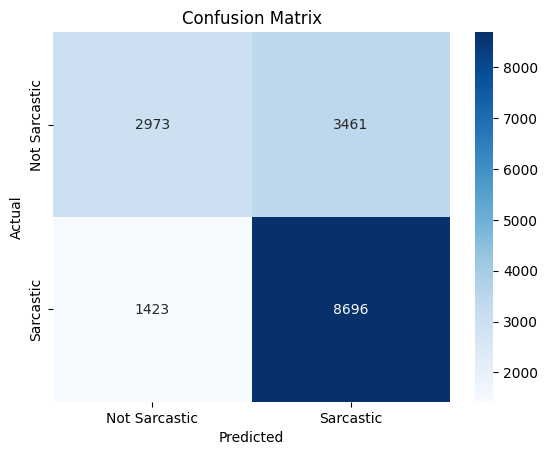

In [81]:
visualise_mat(bert1_conf_matrix)

In [82]:
get_score(bert1_conf_matrix)

Accuracy: 0.7
Precision: 0.72
Recall: 0.86
F1 Score: 0.78


### Change Learning Rate

In [149]:
bert1_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=[Precision(), AUC()])
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert1_lr4_history = bert1_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1656/1656 [==============================] - 6s 3ms/step - loss: 0.6525 - precision_31: 0.6546 - auc_31: 0.6091 - val_loss: 0.6101 - val_precision_31: 0.7178 - val_auc_31: 0.7022
Epoch 2/10
1656/1656 [==============================] - 4s 3ms/step - loss: 0.6075 - precision_31: 0.7026 - auc_31: 0.7001 - val_loss: 0.5879 - val_precision_31: 0.7273 - val_auc_31: 0.7297
Epoch 3/10
1656/1656 [==============================] - 4s 3ms/step - loss: 0.5917 - precision_31: 0.7180 - auc_31: 0.7239 - val_loss: 0.5808 - val_precision_31: 0.7119 - val_auc_31: 0.7377
Epoch 4/10
1656/1656 [==============================] - 4s 3ms/step - loss: 0.5835 - precision_31: 0.7262 - auc_31: 0.7346 - val_loss: 0.5851 - val_precision_31: 0.6928 - val_auc_31: 0.7440
Epoch 5/10
1656/1656 [==============================] - 4s 3ms/step - loss: 0.5768 - precision_31: 0.7310 - auc_31: 0.7436 - val_loss: 0.5748 - val_precision_31: 0.7079 - val_auc_31: 0.7514
Epoch 6/10
1656/1656 [============================

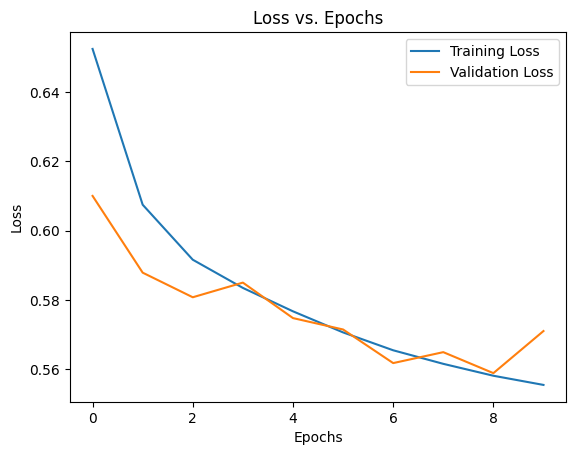

In [150]:
visualise_loss(bert1_lr4_history)

In [ ]:
# Not good becauase it got stuck

### Change Batch Size


In [152]:
# Learning rate change back to 0.001
bert1_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[Precision(), AUC()])
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert1_bs64_history = bert1_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
828/828 [==============================] - 4s 3ms/step - loss: 0.6284 - precision_32: 0.6804 - auc_32: 0.6642 - val_loss: 0.5836 - val_precision_32: 0.7383 - val_auc_32: 0.7339
Epoch 2/10
828/828 [==============================] - 2s 3ms/step - loss: 0.5888 - precision_32: 0.7229 - auc_32: 0.7273 - val_loss: 0.5827 - val_precision_32: 0.7372 - val_auc_32: 0.7343
Epoch 3/10
828/828 [==============================] - 2s 3ms/step - loss: 0.5746 - precision_32: 0.7307 - auc_32: 0.7457 - val_loss: 0.5696 - val_precision_32: 0.7230 - val_auc_32: 0.7504
Epoch 4/10
828/828 [==============================] - 3s 3ms/step - loss: 0.5678 - precision_32: 0.7386 - auc_32: 0.7538 - val_loss: 0.5760 - val_precision_32: 0.7114 - val_auc_32: 0.7551
Epoch 5/10
828/828 [==============================] - 3s 3ms/step - loss: 0.5622 - precision_32: 0.7425 - auc_32: 0.7604 - val_loss: 0.5921 - val_precision_32: 0.8121 - val_auc_32: 0.7558
Epoch 6/10
828/828 [==============================] - 3s 3ms

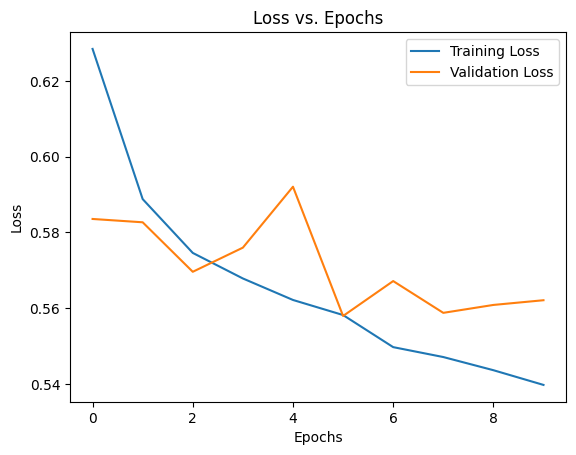

In [153]:
visualise_loss(bert1_bs64_history)

### Change Both Batch Size and Learning Rate

In [211]:
bert1_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=[Precision(), AUC()])
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert1_lr4_bs64_history = bert1_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
828/828 [==============================] - 4s 4ms/step - loss: 0.6522 - precision_49: 0.6545 - auc_49: 0.6094 - val_loss: 0.6128 - val_precision_49: 0.7139 - val_auc_49: 0.6916
Epoch 2/10
828/828 [==============================] - 3s 3ms/step - loss: 0.6096 - precision_49: 0.7054 - auc_49: 0.6969 - val_loss: 0.5924 - val_precision_49: 0.7048 - val_auc_49: 0.7222
Epoch 3/10
828/828 [==============================] - 2s 3ms/step - loss: 0.5936 - precision_49: 0.7205 - auc_49: 0.7210 - val_loss: 0.5804 - val_precision_49: 0.7403 - val_auc_49: 0.7385
Epoch 4/10
828/828 [==============================] - 2s 3ms/step - loss: 0.5840 - precision_49: 0.7302 - auc_49: 0.7344 - val_loss: 0.5751 - val_precision_49: 0.7358 - val_auc_49: 0.7435
Epoch 5/10
828/828 [==============================] - 2s 3ms/step - loss: 0.5774 - precision_49: 0.7348 - auc_49: 0.7425 - val_loss: 0.5708 - val_precision_49: 0.7482 - val_auc_49: 0.7496
Epoch 6/10
828/828 [==============================] - 3s 3ms

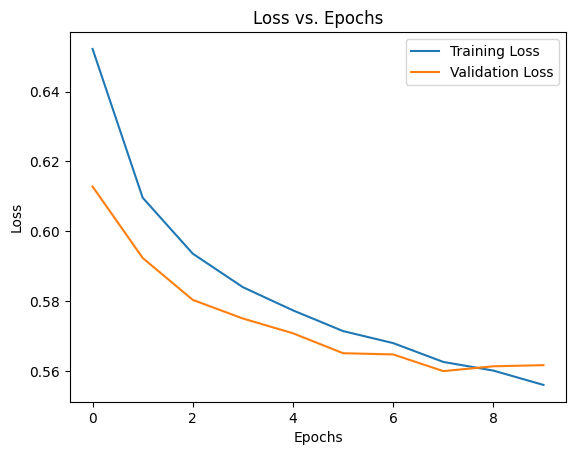

In [212]:
visualise_loss(bert1_lr4_bs64_history)

In [213]:
get_score(get_conf_mat(bert1_model, X_test_padded, y_test))

518/518 [==============================] - 1s 1ms/step
ok
Accuracy: 0.71
Precision: 0.72
Recall: 0.85
F1 Score: 0.78


### RNN with Regularizers

In [157]:
bert2_model = Sequential()

# Add the RNN layer with L2 regularization
bert2_model.add(SimpleRNN(
    16, 
    input_shape=(15, 768), 
    kernel_regularizer=l2(0.001),  # L2 regularization
    recurrent_regularizer=l2(0.001),  # Regularization on recurrent weights
    bias_regularizer=l2(0.001)
))

# Add dropout for regularization
bert2_model.add(Dropout(0.5))  # Increase dropout rate slightly

# Add a BatchNormalization layer to stabilize training
bert2_model.add(BatchNormalization())

# Add the Dense output layer
bert2_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))


In [158]:
# Compile the model
bert2_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=[Precision(), AUC()])

# Train the model
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert2_history = bert2_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
828/828 [==============================] - 7s 7ms/step - loss: 0.8519 - precision_34: 0.6290 - auc_34: 0.5218 - val_loss: 0.6936 - val_precision_34: 0.6576 - val_auc_34: 0.6204
Epoch 2/10
828/828 [==============================] - 3s 3ms/step - loss: 0.7555 - precision_34: 0.6651 - auc_34: 0.5975 - val_loss: 0.6567 - val_precision_34: 0.6985 - val_auc_34: 0.6938
Epoch 3/10
828/828 [==============================] - 3s 4ms/step - loss: 0.7051 - precision_34: 0.6916 - auc_34: 0.6560 - val_loss: 0.6367 - val_precision_34: 0.7245 - val_auc_34: 0.7213
Epoch 4/10
828/828 [==============================] - 3s 4ms/step - loss: 0.6768 - precision_34: 0.7039 - auc_34: 0.6842 - val_loss: 0.6258 - val_precision_34: 0.7386 - val_auc_34: 0.7357
Epoch 5/10
828/828 [==============================] - 3s 3ms/step - loss: 0.6577 - precision_34: 0.7134 - auc_34: 0.7047 - val_loss: 0.6195 - val_precision_34: 0.7226 - val_auc_34: 0.7431
Epoch 6/10
828/828 [==============================] - 3s 3ms

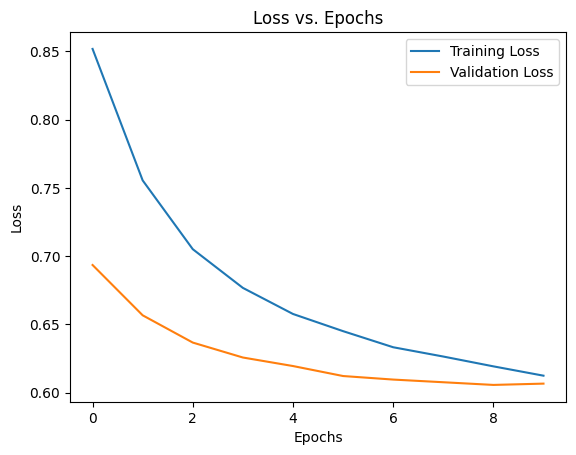

In [159]:
visualise_loss(bert2_history)

In [160]:
get_score(get_conf_mat(bert2_model, X_test_padded, y_test))

518/518 [==============================] - 1s 1ms/step
ok
Accuracy: 0.7
Precision: 0.71
Recall: 0.86
F1 Score: 0.78


### LSTM

In [178]:
bert3_model = Sequential()
bert3_model.add(LSTM(16, input_shape=(15, 768)))
bert3_model.add(Dropout(0.2))
bert3_model.add(Dense(1, activation='sigmoid'))

In [179]:
bert3_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=[Precision(), AUC()])

# Train the model
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert3_history = bert3_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
828/828 [==============================] - 6s 6ms/step - loss: 0.6279 - precision_38: 0.6569 - auc_38: 0.6600 - val_loss: 0.5898 - val_precision_38: 0.7052 - val_auc_38: 0.7246
Epoch 2/10
828/828 [==============================] - 4s 5ms/step - loss: 0.5855 - precision_38: 0.7242 - auc_38: 0.7311 - val_loss: 0.5680 - val_precision_38: 0.7543 - val_auc_38: 0.7534
Epoch 3/10
828/828 [==============================] - 4s 5ms/step - loss: 0.5660 - precision_38: 0.7455 - auc_38: 0.7558 - val_loss: 0.5548 - val_precision_38: 0.7641 - val_auc_38: 0.7670
Epoch 4/10
828/828 [==============================] - 4s 5ms/step - loss: 0.5550 - precision_38: 0.7590 - auc_38: 0.7684 - val_loss: 0.5460 - val_precision_38: 0.7516 - val_auc_38: 0.7770
Epoch 5/10
828/828 [==============================] - 4s 4ms/step - loss: 0.5450 - precision_38: 0.7641 - auc_38: 0.7790 - val_loss: 0.5406 - val_precision_38: 0.7778 - val_auc_38: 0.7815
Epoch 6/10
828/828 [==============================] - 4s 4ms

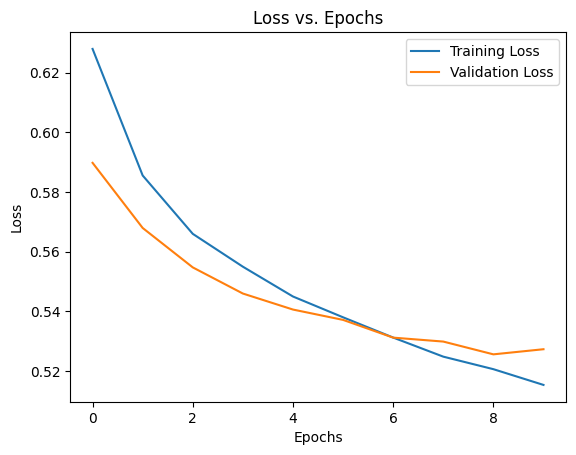

In [180]:
visualise_loss(bert3_history)

In [181]:
get_score(get_conf_mat(bert3_model, X_test_padded, y_test))

518/518 [==============================] - 1s 2ms/step
ok
Accuracy: 0.72
Precision: 0.79
Recall: 0.76
F1 Score: 0.77


### LSTM with Regularizer and more Dropout

In [183]:
bert4_model = Sequential()

# Add the RNN layer with L2 regularization
bert4_model.add(LSTM(
    16, 
    input_shape=(15, 768)
))

# Add dropout for regularization
bert4_model.add(Dropout(0.5))  # Increase dropout rate slightly

# Add a BatchNormalization layer to stabilize training
bert4_model.add(BatchNormalization())

# Add the Dense output layer
bert4_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

In [184]:
bert4_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=[Precision(), AUC()])

# Train the model
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert4_history = bert4_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
828/828 [==============================] - 8s 6ms/step - loss: 0.7411 - precision_39: 0.6812 - auc_39: 0.5977 - val_loss: 0.6304 - val_precision_39: 0.7709 - val_auc_39: 0.7098
Epoch 2/10
828/828 [==============================] - 4s 5ms/step - loss: 0.6483 - precision_39: 0.7035 - auc_39: 0.6690 - val_loss: 0.5827 - val_precision_39: 0.7210 - val_auc_39: 0.7338
Epoch 3/10
828/828 [==============================] - 4s 5ms/step - loss: 0.6048 - precision_39: 0.7101 - auc_39: 0.7119 - val_loss: 0.5675 - val_precision_39: 0.7213 - val_auc_39: 0.7549
Epoch 4/10
828/828 [==============================] - 4s 5ms/step - loss: 0.5830 - precision_39: 0.7205 - auc_39: 0.7382 - val_loss: 0.5562 - val_precision_39: 0.7384 - val_auc_39: 0.7672
Epoch 5/10
828/828 [==============================] - 4s 5ms/step - loss: 0.5705 - precision_39: 0.7291 - auc_39: 0.7532 - val_loss: 0.5476 - val_precision_39: 0.7447 - val_auc_39: 0.7767
Epoch 6/10
828/828 [==============================] - 4s 5ms

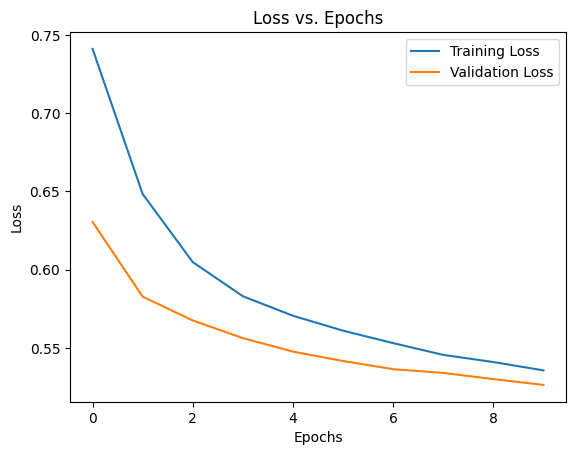

In [185]:
visualise_loss(bert4_history)

In [186]:
get_score(get_conf_mat(bert4_model, X_test_padded, y_test))

518/518 [==============================] - 1s 2ms/step
ok
Accuracy: 0.72
Precision: 0.76
Recall: 0.81
F1 Score: 0.78


### LSTM with Regularizer and same Dropout

In [187]:
bert5_model = Sequential()

# Add the RNN layer with L2 regularization
bert5_model.add(LSTM(
    16, 
    input_shape=(15, 768)
))

# Add dropout for regularization
bert5_model.add(Dropout(0.2))  # Increase dropout rate slightly

# Add a BatchNormalization layer to stabilize training
bert5_model.add(BatchNormalization())

# Add the Dense output layer
bert5_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

In [188]:
bert5_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=[Precision(), AUC()])

# Train the model
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
bert5_history = bert5_model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
828/828 [==============================] - 8s 7ms/step - loss: 0.6876 - precision_40: 0.7034 - auc_40: 0.6365 - val_loss: 0.6220 - val_precision_40: 0.7761 - val_auc_40: 0.7174
Epoch 2/10
828/828 [==============================] - 5s 6ms/step - loss: 0.6095 - precision_40: 0.7201 - auc_40: 0.7080 - val_loss: 0.5853 - val_precision_40: 0.7694 - val_auc_40: 0.7498
Epoch 3/10
828/828 [==============================] - 5s 6ms/step - loss: 0.5833 - precision_40: 0.7268 - auc_40: 0.7390 - val_loss: 0.5593 - val_precision_40: 0.7402 - val_auc_40: 0.7653
Epoch 4/10
828/828 [==============================] - 5s 6ms/step - loss: 0.5668 - precision_40: 0.7364 - auc_40: 0.7575 - val_loss: 0.5493 - val_precision_40: 0.7585 - val_auc_40: 0.7749
Epoch 5/10
828/828 [==============================] - 5s 5ms/step - loss: 0.5564 - precision_40: 0.7434 - auc_40: 0.7687 - val_loss: 0.5415 - val_precision_40: 0.7397 - val_auc_40: 0.7835
Epoch 6/10
828/828 [==============================] - 4s 5ms

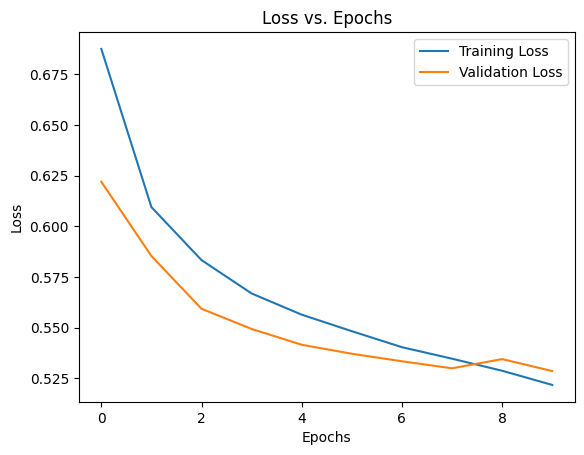

In [190]:
visualise_loss(bert5_history)

In [191]:
bert5_model.evaluate(X_test_padded, y_test)

518/518 [==============================] - 1s 2ms/step - loss: 0.5379 - precision_40: 0.7383 - auc_40: 0.7949


[0.5378825664520264, 0.7383337616920471, 0.7948622107505798]

In [192]:
bert5_mat = get_conf_mat(bert5_model, X_test_padded, y_test)
bert5_mat

518/518 [==============================] - 1s 2ms/step
ok


array([[3378, 3056],
       [1496, 8623]], dtype=int64)

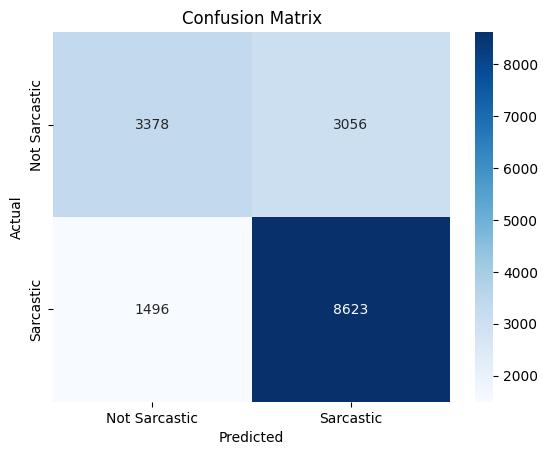

In [193]:
visualise_mat(bert5_mat)

In [194]:
get_score(bert5_mat)

Accuracy: 0.73
Precision: 0.74
Recall: 0.85
F1 Score: 0.79


### Create Model

In [195]:
def create_model():
    model = Sequential([
        LSTM(16, input_shape=(15, 768)),
        Dropout(0.2),
        BatchNormalization(),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
        ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[Precision(), AUC()])
    return model

### Cross Validation For Bert + RNN

In [197]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

fold_matrices = []

X_padded = np.array([pad(seq, desired_shape) for seq in X])

for train_idx, val_idx in kfold.split(X_padded, y):
    # Split data
    X_train, X_val = X_padded[train_idx], X_padded[val_idx]
    y_train, y_val = np.array(y)[train_idx], np.array(y)[val_idx]
    
    # Create a new instance of the model
    model = create_model()
    
    # Train the model
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=2)

    y_val_pred = (model.predict(X_val) > 0.5).astype(int)
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    fold_matrices.append(conf_matrix)


Epoch 1/10
1035/1035 - 7s - loss: 0.6914 - precision_41: 0.6907 - auc_41: 0.6242 - 7s/epoch - 7ms/step
Epoch 2/10
1035/1035 - 5s - loss: 0.6098 - precision_41: 0.7108 - auc_41: 0.7054 - 5s/epoch - 5ms/step
Epoch 3/10
1035/1035 - 5s - loss: 0.5820 - precision_41: 0.7217 - auc_41: 0.7384 - 5s/epoch - 5ms/step
Epoch 4/10
1035/1035 - 5s - loss: 0.5662 - precision_41: 0.7332 - auc_41: 0.7572 - 5s/epoch - 5ms/step
Epoch 5/10
1035/1035 - 5s - loss: 0.5548 - precision_41: 0.7443 - auc_41: 0.7696 - 5s/epoch - 5ms/step
Epoch 6/10
1035/1035 - 7s - loss: 0.5458 - precision_41: 0.7495 - auc_41: 0.7790 - 7s/epoch - 7ms/step
Epoch 7/10
1035/1035 - 15s - loss: 0.5382 - precision_41: 0.7561 - auc_41: 0.7867 - 15s/epoch - 15ms/step
Epoch 8/10
1035/1035 - 14s - loss: 0.5326 - precision_41: 0.7594 - auc_41: 0.7922 - 14s/epoch - 14ms/step
Epoch 9/10
1035/1035 - 14s - loss: 0.5251 - precision_41: 0.7661 - auc_41: 0.7993 - 14s/epoch - 13ms/step
Epoch 10/10
1035/1035 - 4s - loss: 0.5200 - precision_41: 0.7682

### Evaluation

In [198]:
final_matrix = np.array([[0, 0], [0, 0]])
for mat in fold_matrices:
    final_matrix += np.array(mat)

final_matrix

array([[18662, 13051],
       [ 9338, 41713]])

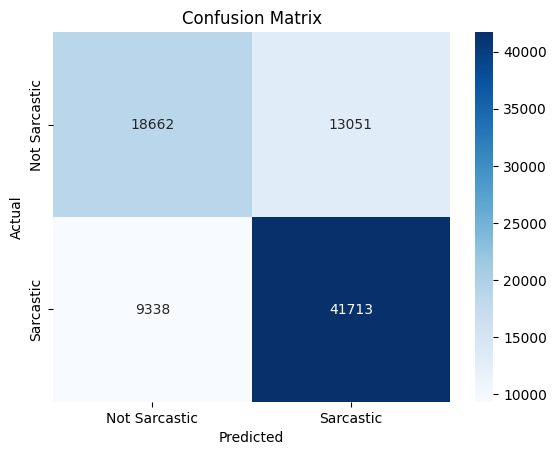

In [199]:
visualise_mat(final_matrix)

In [200]:
get_score(final_matrix)

Accuracy: 0.73
Precision: 0.76
Recall: 0.82
F1 Score: 0.79
